# WebScrapper download files

In [1]:
##### Librerías #####
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import requests
import os

In [2]:

def cargar_datos_estacion(url, carpeta_base, nombre_archivo, skip_filas=7, encoding='utf-8'):
    """
    Descarga un archivo CSV desde la URL especificada, lo guarda localmente y lo carga en un DataFrame de pandas.
    Luego, filtra el DataFrame para incluir solo los datos a partir del año 2014 según la columna 'Fecha', ajusta
    los nombres de las columnas y convierte las columnas (excepto 'Fecha') a tipo numérico.

    Parámetros:
    -----------
    url : str
        URL del archivo CSV a descargar.
    carpeta_base : str
        Carpeta base donde se almacenará el archivo CSV.
    nombre_archivo : str
        Nombre del archivo CSV (sin la ruta de carpeta).
    skip_filas : int, opcional (por defecto = 7)
        Número de filas a omitir al leer el archivo CSV.
    encoding : str, opcional (por defecto = 'utf-8')
        Codificación a utilizar al leer el archivo CSV.

    Retorna:
    --------
    pd.DataFrame
        DataFrame con el contenido del archivo CSV filtrado a partir del año 2014 en la columna 'Fecha', con nombres
        de columnas ajustados y columnas numéricas convertidas a tipo float.
    """

    # Crear la ruta completa del archivo
    ruta_carpeta = os.path.join(carpeta_base)
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    
    # Crear la carpeta si no existe
    os.makedirs(ruta_carpeta, exist_ok=True)

    # Verificar si el archivo existe y su fecha de modificación
    descargar_archivo = True
    if os.path.exists(ruta_archivo):
        # Obtener la fecha de última modificación
        ultima_modificacion = datetime.fromtimestamp(os.path.getmtime(ruta_archivo))
        # Calcular la diferencia en días con la fecha actual
        diferencia_dias = (datetime.now() - ultima_modificacion).days
        print(f"El archivo {nombre_archivo} existe y fue modificado por última vez hace {diferencia_dias} días.")

        # Descargar el archivo sólo si la diferencia con la creación del archivo es mayor a 5 días
        if diferencia_dias <= 5:
            print(f"El archivo tiene menos de 5 días, no se descargará nuevamente.")
            descargar_archivo = False

    # Descargar el archivo si es necesario
    if descargar_archivo:
        try:
            response = requests.get(url)
            response.raise_for_status()  # Verificar que la solicitud fue exitosa
            with open(ruta_archivo, "wb") as f:
                f.write(response.content)
            print(f"Archivo descargado y guardado en: {ruta_archivo}")
        except requests.exceptions.RequestException as e:
            print(f"Error al descargar el archivo: {e}")
            return None

    # Cargar el archivo CSV con pandas
    try:
        df = pd.read_csv(ruta_archivo, encoding=encoding, skiprows=skip_filas)
        print(f"Archivo CSV cargado correctamente desde: {ruta_archivo}")
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")
        return None

    # Limpiar espacios en los nombres de las columnas
    try:
        df.columns = df.columns.str.strip()  # Eliminar espacios al inicio y al final de los nombres de columnas
        print("Espacios en blanco eliminados de los nombres de las columnas.")
    except Exception as e:
        print(f"Error al limpiar los nombres de las columnas: {e}")

    # Convertir la columna 'Fecha' a formato datetime y filtrar a partir del año 2014
    try:
        if 'Fecha' in df.columns:
            df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y/%m/%d', errors='coerce')  # Convertir a datetime
            df = df[df['Fecha'].dt.year >= 2014]  # Filtrar por año >= 2014
            print("Datos filtrados para incluir solo a partir del año 2014.")
        else:
            print("La columna 'Fecha' no se encontró en el DataFrame. No se aplicó el filtrado por año.")
    except Exception as e:
        print(f"Error al filtrar los datos por 'Fecha': {e}")

    # Convertir todas las columnas (excepto 'Fecha') a tipo numérico
    try:
        for col in df.columns:
            if col != 'Fecha':
                df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertir a numérico, forzando errores a NaN
        print("Todas las columnas, excepto 'Fecha', se han convertido a tipo numérico.")
    except Exception as e:
        print(f"Error al convertir las columnas a tipo numérico: {e}")

    return df

In [3]:
#### Descargar y cargar datos de estaciones hidrométricas y climatológicas ####
# 1. Estación Hidrométrica de la Presa de La Boca
url_boca = 'https://sih.conagua.gob.mx/basedatos/Hidros/BOCNL.csv'
df_hidro_boca = cargar_datos_estacion(url_boca, "Bases de datos/Estaciones Hidrométricas", 'BOCNL.csv')

print("-"*120)

# 2. Estación Hidrométrica de Cadereyta
url_cadereyta = 'https://sih.conagua.gob.mx/basedatos/Hidros/CDRNL.csv'
df_hidro_cadereyta = cargar_datos_estacion(url_cadereyta, "Bases de datos/Estaciones Hidrométricas", 'CDRNL.csv')

print("-"*120)

# 3. Estación Climatológica del Centro de Monterrey
url_monterrey = 'https://sih.conagua.gob.mx/basedatos/Climas/MTRNL.csv'
df_clima_mty = cargar_datos_estacion(url_monterrey, "Bases de datos/Estaciones Climatológicas", 'MTRNL.csv')

El archivo BOCNL.csv existe y fue modificado por última vez hace 2 días.
El archivo tiene menos de 5 días, no se descargará nuevamente.
Archivo CSV cargado correctamente desde: Bases de datos/Estaciones Hidrométricas\BOCNL.csv
Espacios en blanco eliminados de los nombres de las columnas.
Datos filtrados para incluir solo a partir del año 2014.
Todas las columnas, excepto 'Fecha', se han convertido a tipo numérico.
------------------------------------------------------------------------------------------------------------------------
El archivo CDRNL.csv existe y fue modificado por última vez hace 2 días.
El archivo tiene menos de 5 días, no se descargará nuevamente.
Archivo CSV cargado correctamente desde: Bases de datos/Estaciones Hidrométricas\CDRNL.csv
Espacios en blanco eliminados de los nombres de las columnas.
Datos filtrados para incluir solo a partir del año 2014.
Todas las columnas, excepto 'Fecha', se han convertido a tipo numérico.
-------------------------------------------

---

## Búsqueda de datos

In [4]:
def obtener_datos_por_fecha(df, columna, fecha_inicio, fecha_fin=None, graficar_top=False, cantidad_top=20):
    """
    Filtra los datos del DataFrame para obtener los valores de la columna especificada 
    en un rango de fechas determinado y genera una gráfica de las fechas con mayores valores.

    Parámetros:
    -----------
    df : pandas.DataFrame
        El DataFrame que contiene los datos a filtrar.
    columna : str
        Nombre de la columna de la cual se desean obtener los valores (e.g., 'Precipitación(mm)', 'Nivel(m)').
    fecha_inicio : str
        Fecha de inicio del rango en formato 'aaaa-mm-dd'.
    fecha_fin : str, opcional
        Fecha de fin del rango en formato 'aaaa-mm-dd'. Si no se especifica, se usará la `fecha_inicio`.
    graficar_top : bool, opcional (por defecto = False)
        Indica si se debe graficar las fechas con mayores valores en la columna especificada.
    cantidad_top : int, opcional (por defecto = 20)
        Número de fechas con mayores valores que se desean mostrar en la gráfica.

    Retorna:
    --------
    pd.DataFrame
        Un DataFrame filtrado que contiene las columnas 'Fecha' y la columna especificada para el rango de fechas.
    """

    # Asegurarse de que la columna 'Fecha' esté en formato datetime
    if 'Fecha' not in df.columns:
        print("La columna 'Fecha' no se encontró en el DataFrame.")
        return None
    
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
    
    # Convertir las fechas de inicio y fin a formato datetime
    fecha_inicio = pd.to_datetime(fecha_inicio)
    fecha_fin = pd.to_datetime(fecha_fin) if fecha_fin else fecha_inicio

    # Filtrar el DataFrame por el rango de fechas usando .loc para evitar SettingWithCopyWarning
    df_filtrado = df.loc[(df['Fecha'] >= fecha_inicio) & (df['Fecha'] <= fecha_fin)].copy()

    # Verificar si la columna especificada existe en el DataFrame
    if columna not in df.columns:
        print(f"La columna '{columna}' no se encontró en el DataFrame.")
        return None

    # Convertir la columna a tipo numérico, forzando errores a NaN
    df_filtrado.loc[:, columna] = pd.to_numeric(df_filtrado[columna], errors='coerce')
    
    # Seleccionar la columna 'Fecha' y la columna de interés, eliminando valores NaN
    df_resultado = df_filtrado[['Fecha', columna]].dropna()

    print(f"Datos filtrados de la columna '{columna}' para el rango de fechas desde {fecha_inicio.date()} hasta {fecha_fin.date()}.")

    # Si se especifica, generar la gráfica de las fechas con mayores valores
    if graficar_top:
        # Obtener las 'cantidad_top' fechas con los valores máximos más altos
        top_datos = df_resultado.nlargest(cantidad_top, columna).sort_values(by=columna, ascending=False)

        # Generar la gráfica
        plt.figure(figsize=(12, 6))
        plt.bar(top_datos['Fecha'].dt.strftime('%Y-%m-%d'), top_datos[columna], color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Fecha')
        plt.ylabel(columna)
        plt.title(f'Top {cantidad_top} fechas con mayor {columna}')
        plt.tight_layout()
        plt.show()

    return df_resultado

### Ejemplo de uso

Datos filtrados de la columna 'Precipitación(mm)' para el rango de fechas desde 2022-01-01 hasta 2022-12-31.


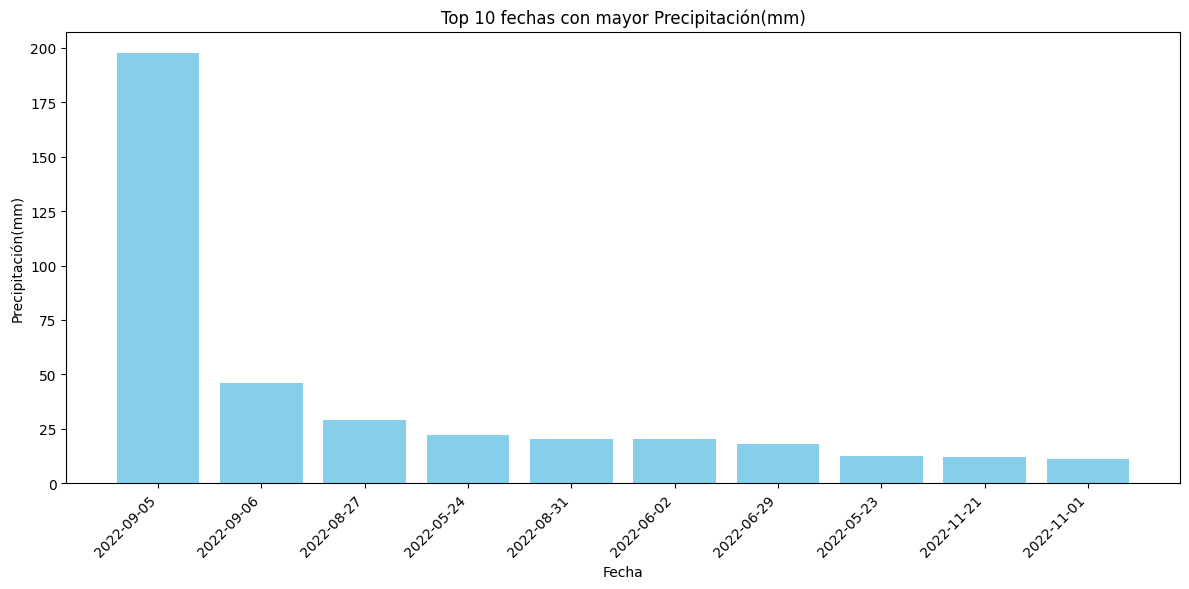

           Fecha  Precipitación(mm)
35095 2022-01-01                0.0
35096 2022-01-02                0.0
35097 2022-01-03                0.0
35098 2022-01-04                0.0
35099 2022-01-05                0.0
...          ...                ...
35455 2022-12-27                0.0
35456 2022-12-28                0.0
35457 2022-12-29                0.0
35458 2022-12-30                0.0
35459 2022-12-31                0.0

[364 rows x 2 columns]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Datos filtrados de la columna 'Nivel(m)' para el rango de fechas desde 2022-01-01 hasta 2022-12-31.


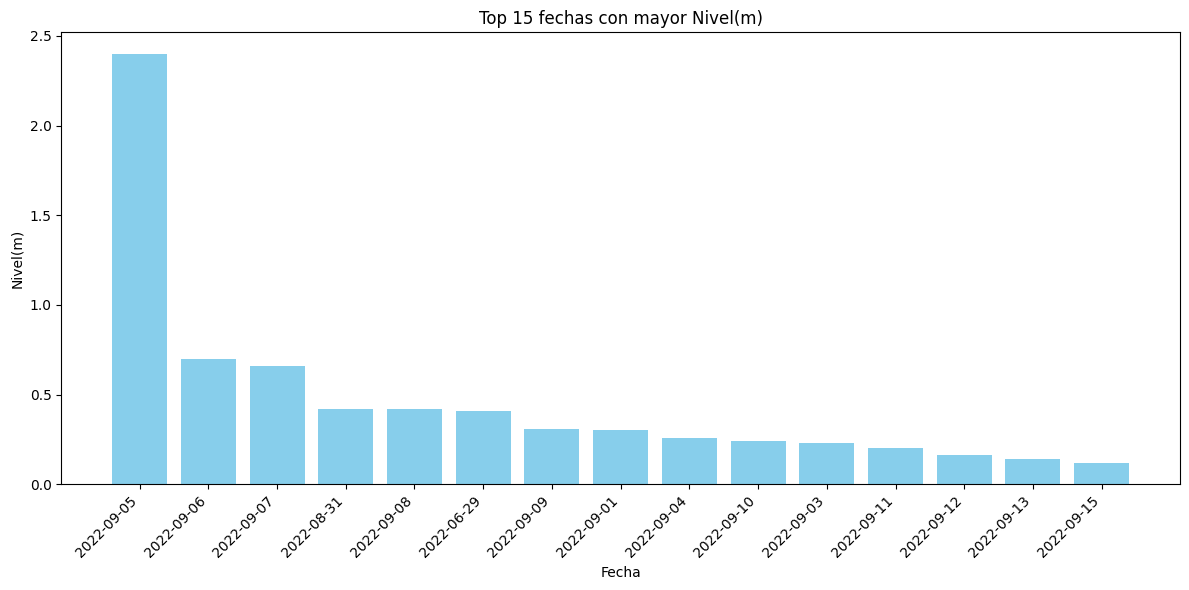

           Fecha  Nivel(m)
10229 2022-01-03      0.00
10230 2022-01-04      0.00
10231 2022-01-05      0.00
10232 2022-01-06      0.00
10233 2022-01-07      0.00
...          ...       ...
10574 2022-12-14      0.02
10575 2022-12-15      0.02
10576 2022-12-16      0.02
10577 2022-12-17      0.02
10578 2022-12-18      0.02

[346 rows x 2 columns]


In [5]:
# Filtrar datos de precipitación para la estación climatológica de Monterrey
df_precipitacion_mty = obtener_datos_por_fecha(df_clima_mty, 'Precipitación(mm)', '2022-01-01', '2022-12-31', graficar_top=True, cantidad_top=10)
print(df_precipitacion_mty)

print("-"*170)
print("-"*170)

# Filtrar datos de nivel para la estación hidrométrica de la Presa de La Boca
df_nivel_boca = obtener_datos_por_fecha(df_hidro_boca, 'Nivel(m)', '2022-01-01', '2022-12-31', graficar_top=True, cantidad_top=15)
print(df_nivel_boca)

---

# Relación con Tweets

In [6]:
def obtener_fechas_unicas_tweets(ruta_archivo, nombre_columna='Fecha'):
    """
    Carga un archivo CSV de tweets, convierte la columna de 'Fecha' a formato datetime,
    y devuelve un DataFrame con fechas únicas en las que se registraron tweets.

    Parámetros:
    -----------
    ruta_archivo : str
        Ruta del archivo CSV que contiene los tweets.
    nombre_columna : str, opcional (por defecto = 'Fecha')
        Nombre de la columna en el CSV que contiene las fechas de los tweets.

    Retorna:
    --------
    pd.DataFrame
        Un DataFrame que contiene solo las fechas únicas (sin horas) en las que se registraron tweets.
    """

    # Cargar el archivo CSV con los tweets
    try:
        df_tweets = pd.read_csv(ruta_archivo, encoding='utf-8')
        print(f"Archivo cargado correctamente desde: {ruta_archivo}")
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")
        return None

    # Convertir la columna de 'Fecha' a formato datetime
    try:
        df_tweets[nombre_columna] = pd.to_datetime(df_tweets[nombre_columna], format='%b %d, %Y · %I:%M %p %Z', errors='coerce')
        print(f"Columna '{nombre_columna}' convertida a formato datetime.")
    except Exception as e:
        print(f"Error al convertir la columna '{nombre_columna}' a formato datetime: {e}")
        return None

    # Extraer la fecha (sin considerar la hora)
    df_tweets['Fecha_sin_hora'] = df_tweets[nombre_columna].dt.date

    # Obtener las fechas únicas
    fechas_unicas = df_tweets['Fecha_sin_hora'].dropna().unique()

    # Crear un nuevo DataFrame con las fechas únicas
    df_fechas_unicas = pd.DataFrame(fechas_unicas, columns=['Fecha'])

    print(f"Se encontraron {len(fechas_unicas)} fechas únicas con tweets.")
    return df_fechas_unicas

# Ejemplo de uso:
ruta_tweets = "Bases de datos/Base_tweets.csv"
df_fechas_tweets = obtener_fechas_unicas_tweets(ruta_tweets)
display(df_fechas_tweets)


Archivo cargado correctamente desde: Bases de datos/Base_tweets.csv
Columna 'Fecha' convertida a formato datetime.
Se encontraron 123 fechas únicas con tweets.


,Fecha
0,2024-06-21
1,2024-06-20
2,2024-06-19
3,2024-06-18
4,2024-06-17
...,...
118,2024-06-25
119,2024-07-15
120,2024-07-06
121,2024-03-24


In [16]:
# def obtener_datos_estaciones_por_fechas(df_hidro_boca, df_hidro_cadereyta, df_clima_mty, df_fechas_tweets):
#     """
#     Filtra los datos de precipitación y nivel de las estaciones hidrométricas y climatológicas
#     para las fechas en las que se registraron tweets durante el año 2024, y grafica los resultados.

#     Parámetros:
#     -----------
#     df_hidro_boca : pd.DataFrame
#         DataFrame con los datos de la estación hidrométrica de la Presa de La Boca.
#     df_hidro_cadereyta : pd.DataFrame
#         DataFrame con los datos de la estación hidrométrica de Cadereyta.
#     df_clima_mty : pd.DataFrame
#         DataFrame con los datos de la estación climatológica del Centro de Monterrey.
#     df_fechas_tweets : pd.DataFrame
#         DataFrame con las fechas únicas en las que se registraron tweets.

#     Retorna:
#     --------
#     None
#     """

#     # Asegurarse de que la columna 'Fecha' esté en formato datetime en todos los DataFrames
#     for df in [df_hidro_boca, df_hidro_cadereyta, df_clima_mty, df_fechas_tweets]:
#         if 'Fecha' in df.columns:
#             df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

#     # Extraer solo las fechas únicas de df_fechas_tweets y filtrar para el año 2024
#     df_fechas_tweets = df_fechas_tweets[df_fechas_tweets['Fecha'].dt.year == 2024]
#     fechas_unicas = df_fechas_tweets['Fecha'].dt.date.unique()

#     # Filtrar datos de las estaciones por las fechas de los tweets y solo del año 2024
#     df_nivel_boca = df_hidro_boca[(df_hidro_boca['Fecha'].dt.date.isin(fechas_unicas)) & (df_hidro_boca['Fecha'].dt.year == 2024)][['Fecha', 'Nivel(m)']]
#     df_nivel_cadereyta = df_hidro_cadereyta[(df_hidro_cadereyta['Fecha'].dt.date.isin(fechas_unicas)) & (df_hidro_cadereyta['Fecha'].dt.year == 2024)][['Fecha', 'Nivel(m)']]
#     df_precipitacion_mty = df_clima_mty[(df_clima_mty['Fecha'].dt.date.isin(fechas_unicas)) & (df_clima_mty['Fecha'].dt.year == 2024)][['Fecha', 'Precipitación(mm)']]

#     # Asegurarse de que los datos estén ordenados por fecha
#     df_nivel_boca.sort_values(by='Fecha', inplace=True)
#     df_nivel_cadereyta.sort_values(by='Fecha', inplace=True)
#     df_precipitacion_mty.sort_values(by='Fecha', inplace=True)

#     # Convertir las fechas a formato datetime.date para usar en los gráficos y en el set_xlim
#     df_nivel_boca['Fecha'] = df_nivel_boca['Fecha'].dt.date
#     df_nivel_cadereyta['Fecha'] = df_nivel_cadereyta['Fecha'].dt.date
#     df_precipitacion_mty['Fecha'] = df_precipitacion_mty['Fecha'].dt.date

#     # Obtener la fecha mínima y máxima del rango común dentro del año 2024
#     fecha_min = min(df_nivel_boca['Fecha'].min(), df_nivel_cadereyta['Fecha'].min(), df_precipitacion_mty['Fecha'].min())
#     fecha_max = max(df_nivel_boca['Fecha'].max(), df_nivel_cadereyta['Fecha'].max(), df_precipitacion_mty['Fecha'].max())

#     # Crear un subplot con 3 filas y 1 columna
#     fig, axs = plt.subplots(3, 1, figsize=(12, 8))

#     # Gráfico de Precipitación en Monterrey
#     axs[0].bar(df_precipitacion_mty['Fecha'], df_precipitacion_mty['Precipitación(mm)'], color='skyblue')
#     axs[0].set_title('Precipitación en Monterrey (2024)')
#     axs[0].set_xlabel('Fecha')
#     axs[0].set_ylabel('Precipitación (mm)')
#     axs[0].tick_params(axis='x', rotation=45)
#     axs[0].set_xlim([fecha_min, fecha_max])  # Configurar límite del eje X

#     # Gráfico de Nivel en la Presa de La Boca
#     axs[1].plot(df_nivel_boca['Fecha'], df_nivel_boca['Nivel(m)'], color='orange')
#     axs[1].set_title('Nivel en La Boca (2024)')
#     axs[1].set_xlabel('Fecha')
#     axs[1].set_ylabel('Nivel (m)')
#     axs[1].tick_params(axis='x', rotation=45)
#     axs[1].set_xlim([fecha_min, fecha_max])  # Configurar límite del eje X

#     # Gráfico de Nivel en Cadereyta
#     axs[2].plot(df_nivel_cadereyta['Fecha'], df_nivel_cadereyta['Nivel(m)'], color='green')
#     axs[2].set_title('Nivel en Cadereyta (2024)')
#     axs[2].set_xlabel('Fecha')
#     axs[2].set_ylabel('Nivel (m)')
#     axs[2].tick_params(axis='x', rotation=45)
#     axs[2].set_xlim([fecha_min, fecha_max])  # Configurar límite del eje X

#     plt.tight_layout()
#     plt.show()


# # Ejemplo de uso:
# obtener_datos_estaciones_por_fechas(df_hidro_boca, df_hidro_cadereyta, df_clima_mty, df_fechas_tweets)

############# FUNCIÓN QUE SÓLO DEVUELVE Y NO GRAFICA #############
def obtener_datos_estaciones_por_fechas(df_hidro_boca, df_hidro_cadereyta, df_clima_mty, df_fechas_tweets):
    """
    Filtra los datos de precipitación y nivel de las estaciones hidrométricas y climatológicas
    para las fechas en las que se registraron tweets durante el año 2024, y devuelve los DataFrames.

    Parámetros:
    -----------
    df_hidro_boca : pd.DataFrame
        DataFrame con los datos de la estación hidrométrica de la Presa de La Boca.
    df_hidro_cadereyta : pd.DataFrame
        DataFrame con los datos de la estación hidrométrica de Cadereyta.
    df_clima_mty : pd.DataFrame
        DataFrame con los datos de la estación climatológica del Centro de Monterrey.
    df_fechas_tweets : pd.DataFrame
        DataFrame con las fechas únicas en las que se registraron tweets.

    Retorna:
    --------
    df_nivel_boca : pd.DataFrame
        DataFrame filtrado con los datos de nivel de la Presa de La Boca para las fechas seleccionadas.
    df_nivel_cadereyta : pd.DataFrame
        DataFrame filtrado con los datos de nivel de Cadereyta para las fechas seleccionadas.
    df_precipitacion_mty : pd.DataFrame
        DataFrame filtrado con los datos de precipitación de Monterrey para las fechas seleccionadas.
    """

    # Asegurarse de que la columna 'Fecha' esté en formato datetime en todos los DataFrames
    for df in [df_hidro_boca, df_hidro_cadereyta, df_clima_mty, df_fechas_tweets]:
        if 'Fecha' in df.columns:
            df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

    # Extraer solo las fechas únicas de df_fechas_tweets y filtrar para el año 2024
    df_fechas_tweets = df_fechas_tweets[df_fechas_tweets['Fecha'].dt.year == 2024]
    fechas_unicas = df_fechas_tweets['Fecha'].dt.date.unique()

    # Filtrar datos de las estaciones por las fechas de los tweets y solo del año 2024
    df_nivel_boca = df_hidro_boca[(df_hidro_boca['Fecha'].dt.date.isin(fechas_unicas)) & (df_hidro_boca['Fecha'].dt.year == 2024)][['Fecha', 'Nivel(m)']]
    df_nivel_cadereyta = df_hidro_cadereyta[(df_hidro_cadereyta['Fecha'].dt.date.isin(fechas_unicas)) & (df_hidro_cadereyta['Fecha'].dt.year == 2024)][['Fecha', 'Nivel(m)']]
    df_precipitacion_mty = df_clima_mty[(df_clima_mty['Fecha'].dt.date.isin(fechas_unicas)) & (df_clima_mty['Fecha'].dt.year == 2024)][['Fecha', 'Precipitación(mm)']]

    # Asegurarse de que los datos estén ordenados por fecha
    df_nivel_boca.sort_values(by='Fecha', inplace=True)
    df_nivel_cadereyta.sort_values(by='Fecha', inplace=True)
    df_precipitacion_mty.sort_values(by='Fecha', inplace=True)

    # Convertir las fechas a formato datetime.date
    df_nivel_boca['Fecha'] = df_nivel_boca['Fecha'].dt.date
    df_nivel_cadereyta['Fecha'] = df_nivel_cadereyta['Fecha'].dt.date
    df_precipitacion_mty['Fecha'] = df_precipitacion_mty['Fecha'].dt.date

    return df_nivel_boca, df_nivel_cadereyta, df_precipitacion_mty

# Ejemplo de uso:
df_nivel_boca, df_nivel_cadereyta, df_precipitacion_mty = obtener_datos_estaciones_por_fechas(df_hidro_boca, df_hidro_cadereyta, df_clima_mty, df_fechas_tweets)

In [17]:
df_precipitacion_mty.head()

,Fecha,Precipitación(mm)
35840,2024-01-16,0.7
35846,2024-01-22,5.7
35855,2024-01-31,0.0
35859,2024-02-04,0.0
35864,2024-02-09,0.0


---
# Experimentación

In [8]:
# # Descargar txt desde 'https://smn.conagua.gob.mx/tools/RESOURCES/Normales_Climatologicas/Diarios/nl/dia19052.txt'
# url = 'https://smn.conagua.gob.mx/tools/RESOURCES/Normales_Climatologicas/Diarios/nl/dia19052.txt'
# nombre_archivo = 'normales_climatologicas.txt'
# ruta_archivo = os.path.join("Bases de datos", nombre_archivo)

# # Descargar el archivo
# try:
#     response = requests.get(url)
#     response.raise_for_status()  # Verificar que la solicitud fue exitosa
#     with open(ruta_archivo, "wb") as f:
#         f.write(response.content)
#     print(f"Archivo descargado y guardado en: {ruta_archivo}")
# except requests.exceptions.RequestException as e:
#     print(f"Error al descargar el archivo: {e}")

# # Leer el archivo descargado
# with open(ruta_archivo, 'r') as f:
#     lineas = f.readlines()

# # Mostrar las primeras 10 líneas del archivo
# print("Primeras 10 líneas del archivo:")
# for linea in lineas[:10]:
#     print(linea)

---
# Integración NLP y series de tiempo

In [18]:
# Cargar df_tweets desde 'Base_tweets.csv'
df_tweets = pd.read_csv('Bases de datos/Base_tweets.csv')

In [24]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Cargar el modelo y el tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Cargar los DataFrames `df_tweets` y `df_precipitacion_mty` (asumiendo que ya están cargados en el entorno)
# df_tweets -> Contiene las columnas 'Texto', 'Fecha', y 'Puntaje'
# df_precipitacion_mty -> Contiene las columnas 'Fecha' y 'Precipitación(mm)'

# Convertir la columna 'Fecha' a formato datetime en ambos DataFrames
df_tweets['Fecha'] = pd.to_datetime(df_tweets['Fecha'], format='%b %d, %Y · %I:%M %p %Z', errors='coerce')
df_precipitacion_mty['Fecha'] = pd.to_datetime(df_precipitacion_mty['Fecha'], format='%Y-%m-%d', errors='coerce')

# Normalizar ambas columnas de 'Fecha' para que no tengan zona horaria (remover tzinfo)
df_tweets['Fecha'] = df_tweets['Fecha'].dt.tz_localize(None)
df_precipitacion_mty['Fecha'] = df_precipitacion_mty['Fecha'].dt.tz_localize(None)

# Crear una columna que indique si llovió en la fecha correspondiente (Precipitación > 0)
df_precipitacion_mty['Día_Lluvioso'] = df_precipitacion_mty['Precipitación(mm)'].apply(lambda x: 1 if x > 0 else 0)

# Unir `df_tweets` con `df_precipitacion_mty` utilizando la columna 'Fecha'
df_merged = pd.merge(df_tweets, df_precipitacion_mty[['Fecha', 'Día_Lluvioso']], on='Fecha', how='left')

# Rellenar valores NaN en 'Día_Lluvioso' con 0 (en caso de que haya fechas que no tengan registro en `df_precipitacion_mty`)
df_merged['Día_Lluvioso'].fillna(0, inplace=True)

# Función para calcular la puntuación de sentimiento usando el modelo preentrenado y ajustar según la lluvia
def calculate_sentiment_with_date(text, day_context):
    # Calcular el sentimiento usando el modelo preentrenado
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    scores = softmax(scores[0])
    sentiment_labels = [-2, -1, 0, 1, 2]  # Valores predefinidos del modelo de sentimiento
    sentiment_score = sum([a * b for a, b in zip(sentiment_labels, scores)])

    # Ajuste basado en si el día fue lluvioso o no (ajuste simple en este caso)
    if day_context == 1:  # Día lluvioso
        sentiment_score -= 0.5  # Reducir un poco el puntaje si es un día lluvioso (ajuste ajustable)
    return sentiment_score

# Aplicar la función a cada texto en el DataFrame unido
df_merged['Puntaje_ajustado'] = df_merged.apply(lambda row: calculate_sentiment_with_date(row['Texto'], row['Día_Lluvioso']), axis=1)

# Reordenar las columnas para que 'Puntaje_ajustado' aparezca justo después de 'Puntaje'
# Primero obtenemos la lista de columnas del DataFrame
columnas = list(df_merged.columns)

# Encontrar la posición de la columna 'Puntaje' (asumiendo que existe en el DataFrame)
if 'Puntaje' in columnas:
    indice_puntaje = columnas.index('Puntaje')
else:
    indice_puntaje = len(columnas) - 1  # Si 'Puntaje' no existe, colocamos la nueva columna al final de las columnas actuales

# Crear el nuevo orden de columnas colocando 'Puntaje_ajustado' después de 'Puntaje'
nueva_orden = columnas[:indice_puntaje + 1] + ['Puntaje_ajustado'] + [col for col in columnas if col not in ['Puntaje_ajustado', 'Puntaje']]

# Reordenar el DataFrame según la nueva disposición de columnas
df_merged = df_merged[nueva_orden]

# Guardar el DataFrame ajustado con la nueva columna en el orden deseado
df_merged.to_csv('./Bases de datos/df_sentimientos_ajustados_con_precipitacion.csv', index=False)

print("Proceso completado y DataFrame guardado con éxito.")

c:\Users\aesca\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(

Proceso completado y DataFrame guardado con éxito.
